In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from sklearn import metrics
import sklearn
import warnings
warnings.filterwarnings("ignore")
import itertools
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
import plotly 
import plotly.express as px
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
import shap
from catboost import Pool
from sklearn.ensemble import RandomForestRegressor
from rfpimp import permutation_importances
import eli5
from eli5.sklearn import PermutationImportance
from treeinterpreter import treeinterpreter as ti, utils
from sklearn import metrics


### All features without network metrics

In [6]:
data = pd.read_csv(r"C:\Users\aalimov002\Desktop\data_with_clusters.csv")
data=data.drop(['Unnamed: 0', 'Position'],axis=1)

In [7]:

data['Foot'] = data['Foot'].replace('right', 1)
data['Foot'] = data['Foot'].replace('left', 0)
data['Foot'] = data['Foot'].replace('both', 2)
#data=data[data['Transfer_value']<15000000]
Player = data['Player']
data=data.drop(['Player'],axis=1)
target = data['Transfer_value']
data = data.drop(['Transfer_value'],axis=1)
data=data.astype('int')

In [6]:
data= data.drop(['total_passes_closeness', 'total_passes_betw', 'total_passes_pagerank',
       'total_passes_transitivity', 'forward_passes_closeness',
       'forward_passes_betw', 'forward_passes_pagerank',
       'forward_passes_transitivity', 'back_passes_closeness',
       'back_passes_betw', 'back_passes_pagerank', 'back_passes_transitivity',
       'long_passes_closeness', 'long_passes_betw', 'long_passes_pagerank',
       'long_passes_transitivity', 'final_3rd_passes_closeness',
       'final_3rd_passes_betw', 'final_3rd_passes_pagerank',
       'final_3rd_passes_transitivity', 'progressive_passes_closeness',
       'progressive_passes_betw', 'progressive_passes_pagerank','progressive_passes_transitivity'],axis=1)

data['Age**2'] = data['Age']**2

In [7]:
for i in range(0, data.shape[1]):
    data.iloc[:,i]= data.iloc[:,i] + 0.0000001
    data.iloc[:,i] = (data.iloc[:,i] - data.iloc[:,i].mean() ) / np.std(data.iloc[:,i])

    
target = np.log(target)    

In [8]:
model = CatBoostRegressor(loss_function='RMSE', depth=4, learning_rate=0.05,l2_leaf_reg=0.2,iterations=1000, verbose=False)

In [9]:
model.fit(data, target)
predictions=model.predict(data)

In [10]:
check = pd.DataFrame(Player)
check['initial'] = target
check['pred'] = predictions
check['initial'] = np.exp(check['initial'])
check['pred'] = np.exp(check['pred'])
check['diff'] = abs(check['initial'] - check['pred'])

In [11]:
print('mean absolute error in euro:',check['diff'].mean())
print('metric:', metrics.mean_absolute_error(target, predictions))

mean absolute error in euro: 101116.09448742475
metric: 0.06873438887100386


In [229]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.log(check['pred']),
    name='predicted',
    mode='markers',
    marker_color='rgb(199, 0, 0)', hovertext=check['Player']
))

fig.add_trace(go.Scatter(
    x=np.log(check['initial']),
    name='actual',
    marker_color='rgb(8, 0, 254)',hovertext=check['Player']
))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Styled Scatter', 
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

### All features with network metrics

In [12]:
data = pd.read_csv(r"C:\Users\aalimov002\Desktop\data_with_clusters.csv")
data=data.drop(['Unnamed: 0', 'Position'],axis=1)
data['Foot'] = data['Foot'].replace('right', 1)
data['Foot'] = data['Foot'].replace('left', 0)
data['Foot'] = data['Foot'].replace('both', 2)
#data=data[data['Transfer_value']<15000000]
Player = data['Player']
data=data.drop(['Player'],axis=1)
target = data['Transfer_value']
data = data.drop(['Transfer_value'],axis=1)
data=data.astype('int')

In [13]:
data['Age*2'] = data['Age']**2
for i in range(0, data.shape[1]):
    data.iloc[:,i]= data.iloc[:,i] + 0.0000001
    data.iloc[:,i] = (data.iloc[:,i] - data.iloc[:,i].mean() ) / np.std(data.iloc[:,i])

    
target = np.log(target)    

In [14]:
model = CatBoostRegressor(loss_function='RMSE', depth=4, learning_rate=0.05,l2_leaf_reg=0.2,iterations=1000, verbose=False)

In [15]:
model.fit(data, target)
predictions=model.predict(data)

In [16]:
check = pd.DataFrame(Player)
check['initial'] = target
check['pred'] = predictions
check['initial'] = np.exp(check['initial'])
check['pred'] = np.exp(check['pred'])
check['diff'] = abs(check['initial'] - check['pred'])

In [17]:
print('mean absolute error in euro:',check['diff'].mean())
print('metric:', metrics.mean_absolute_error(target, predictions))

mean absolute error in euro: 79132.8571276912
metric: 0.060996365985509705


In [236]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.log(check['pred']),
    name='predicted',
    mode='markers',
    marker_color='rgb(199, 0, 0)', hovertext=check['Player']
))

fig.add_trace(go.Scatter(
    x=np.log(check['initial']),
    name='actual',
    marker_color='rgb(8, 0, 254)',hovertext=check['Player']
))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Styled Scatter', 
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

### Feature selection

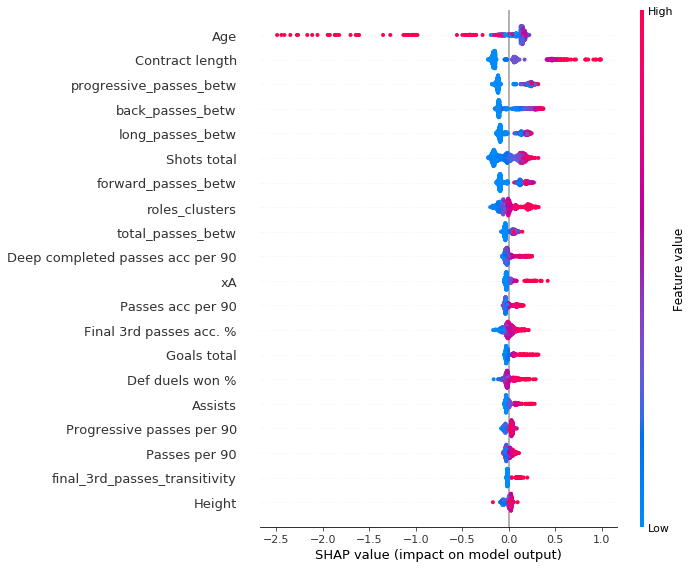

In [237]:
shap_values = model.get_feature_importance(Pool(data, label=target,), 
                                                                     type="ShapValues")

shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, data)

In [9]:
im = pd.DataFrame()
im['features'] = data.columns
im['fi'] = model.feature_importances_
im = im.sort_values(by='fi', ascending=True)
im.head(15)

,features,fi
13,Head goals per 90,0.000000
41,Red cards per 90,0.000000
42,Second assists per 90,0.000000
43,Third assists per 90,0.000000
19,Assists per 90,0.000000
46,Key passes per 90,0.000000
76,forward_passes_pagerank,0.000000
35,Shots blocked per 90,0.000000
11,Non-penalty goals per 90,0.000000
39,Yellow cards per 90,0.000000


### Best model

In [27]:
data = pd.read_csv(r"C:\Users\aalimov002\Desktop\data_with_clusters.csv")
data=data.drop(['Unnamed: 0', 'Position'],axis=1)
data['Foot'] = data['Foot'].replace('right', 1)
data['Foot'] = data['Foot'].replace('left', 0)
data['Foot'] = data['Foot'].replace('both', 2)
#data=data[data['Transfer_value']<15000000]
Player = data['Player']
data=data.drop(['Player'],axis=1)
target = data['Transfer_value']
data = data.drop(['Transfer_value'],axis=1)
data=data.astype('int')

In [28]:
data['Age*2'] = data['Age']**2
data=data.drop(['Assists per 90', 'Foot', 'Shots blocked per 90','Goals per 90','Non-penalty goals per 90','Key passes per 90',
               'Head goals per 90', 'Yellow cards per 90','forward_passes_pagerank','Third assists per 90',
               'Second assists per 90','Red cards per 90','progressive_passes_closeness','long_passes_pagerank'],axis=1)

In [29]:
for i in range(0, data.shape[1]):
    data.iloc[:,i]= data.iloc[:,i] + 0.0000001
    data.iloc[:,i] = (data.iloc[:,i] - data.iloc[:,i].mean() ) / np.std(data.iloc[:,i])

    
target = np.log(target)    

In [30]:
model = CatBoostRegressor(loss_function='RMSE', depth=4, learning_rate=0.05,l2_leaf_reg=0.2,iterations=1000, verbose=False)

In [31]:
model.fit(data, target)
predictions=model.predict(data)

In [32]:
check = pd.DataFrame(Player)
check['initial'] = target
check['pred'] = predictions
check['initial'] = np.exp(check['initial'])
check['pred'] = np.exp(check['pred'])
check['diff'] = abs(check['initial'] - check['pred'])

In [33]:
print('mean absolute error in euro:',check['diff'].mean())
print('metric:', metrics.mean_absolute_error(target, predictions))

mean absolute error in euro: 82241.86002717109
metric: 0.06337614575862555


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.log(check['pred']),
    name='predicted',
    mode='markers',
    marker_color='rgb(199, 0, 0)', hovertext=check['Player']
))

fig.add_trace(go.Scatter(
    x=np.log(check['initial']),
    name='actual',
    marker_color='rgb(8, 0, 254)',hovertext=check['Player']
))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Styled Scatter', 
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig.show()

### Comparison with rf feature selection

In [247]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df
def mean_squared_error(target, predictions):
    return mean_squared_error(target, rf.predict(data))



In [248]:
data = pd.read_csv(r"C:\Users\aalimov002\Desktop\data_with_clusters.csv")
data=data.drop(['Unnamed: 0', 'Position'],axis=1)
data['Foot'] = data['Foot'].replace('right', 1)
data['Foot'] = data['Foot'].replace('left', 0)
data['Foot'] = data['Foot'].replace('both', 2)
Player = data['Player']
data=data.drop(['Player'],axis=1)
target = data['Transfer_value']
data = data.drop(['Transfer_value'],axis=1)
data=data.astype('int')

In [249]:
for i in range(0, data.shape[1]):
    data.iloc[:,i]= data.iloc[:,i] + 0.0000001
    data.iloc[:,i] = (data.iloc[:,i] - data.iloc[:,i].mean() ) / np.std(data.iloc[:,i])
    
target = np.log(target)    

In [250]:
rf = RandomForestRegressor(n_estimators = 80,
                           n_jobs = -1,
                           random_state = 42)

In [251]:
rf.fit(data, target)
predictions = rf.predict(data)

In [252]:
im = pd.DataFrame()
im['features'] = data.columns
im['fi'] = rf.feature_importances_
im = im.sort_values(by='fi', ascending=False)
im['fi']=im['fi'].round(5)
im.head(15)

,features,fi
0,Age,0.15731
79,back_passes_betw,0.11615
75,forward_passes_betw,0.10127
83,long_passes_betw,0.08948
91,progressive_passes_betw,0.07437
110,Contract length,0.07174
14,Shots total,0.04846
103,Deep completed passes acc per 90,0.02671
94,roles_clusters,0.01806
18,Assists,0.01185


In [253]:
perm = PermutationImportance(rf,  refit = False, n_iter = 3, scoring='neg_mean_squared_error').fit(data, target)
perm_imp_eli5 = imp_df(data.columns, perm.feature_importances_)
perm_imp_eli5['feature_importance'] = perm_imp_eli5['feature_importance'].round(5)
perm_imp_eli5 = perm_imp_eli5.sort_values(by='feature_importance', ascending=False).head(15)

In [254]:
perm_imp_eli5.head(15)

,feature,feature_importance
0,Age,0.40937
1,back_passes_betw,0.17633
2,Contract length,0.17140
3,Shots total,0.11749
4,forward_passes_betw,0.09750
5,long_passes_betw,0.07238
6,progressive_passes_betw,0.05821
7,roles_clusters,0.03897
8,Deep completed passes acc per 90,0.03289
9,Passes acc per 90,0.01503
